# Generate maps of metrics

This notebook shows how to generate maps of various metrics



In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [3]:
from os import chdir
if "_changed_dir" not in locals():
    chdir("..")
    _changed_dir = True

In [4]:
from model_analysis import *

## Load base data

### Load geographic data


In [5]:
geo = gpd.read_file('./data/processed/geo/covid19model_zones.shp')  

### Load run manifests

In [6]:
run_manifest = read_manifest('run-manifest.csv')
analysis_set = get_analysis_set(run_manifest)

### select a run

In [7]:
run_data = analysis_set.iloc[-1,]

### Match country names between geo and model

In [8]:
geo_fra_regions = ["France", *[i for i in geo.name[geo.geo_level == "REG"].unique()]]
model_regions = run_data.model.data["ifr"].region
model_countries = run_data.model.data["ifr"].country

prob_match = {}
for zone in model_regions[model_regions != model_countries].unique():
    prob_match[zone] = icl_translate.most_probable_match(zone, geo_fra_regions)

# Print French 
print(geo_fra_regions)

# Hard code failures (due to complete name mismatch)
prob_match['Grand Est'] = 'ALSACE-CHAMPAGNE-ARDENNE-LORRAINE'
prob_match['Hauts-de-France'] = 'NORD-PAS-DE-CALAIS-PICARDIE'
prob_match['Nouvelle-Aquitaine'] = 'AQUITAINE-LIMOUSIN-POITOU-CHARENTES'
prob_match['Occitanie'] = 'LANGUEDOC-ROUSSILLON-MIDI-PYRENEES'

Match 1 of 1 : 'AUVERGNE-RHONE-ALPES' == 'Auvergne-Rhône-Alpes'  with a match score of 35/80.
	Match 1 of 1 : 'BOURGOGNE-FRANCHE-COMTE' == 'Bourgogne-Franche-Comté'  with a match score of 49/92.
	Match 1 of 1 : 'BRETAGNE' == 'Bretagne'  with a match score of 18/32.
	Match 1 of 1 : 'CENTRE-VAL DE LOIRE' == 'Centre-Val de Loire'  with a match score of 46/76.
	Match 1 of 1 : 'CORSE' == 'Corse'  with a match score of 12/20.
	Match 1 of 1 : 'France' == 'Grand Est'  with a match score of 9/36.
	Match 1 of 1 : 'France' == 'Hauts-de-France'  with a match score of 24/60.
	Match 1 of 1 : 'NORMANDIE' == 'Normandie'  with a match score of 20/36.
	Match 1 of 1 : 'GUYANE' == 'Nouvelle-Aquitaine'  with a match score of 4/72.
	Match 1 of 1 : 'France' == 'Occitanie'  with a match score of 4/36.
	Match 1 of 1 : 'PAYS DE LA LOIRE' == 'Pays de la Loire'  with a match score of 39/64.
	Match 1 of 1 : 'PROVENCE-ALPES-COTE D'AZUR' == 'Provence-Alpes-Côte d'Azur'  with a match score of 49/104.
	Match 1 of 1 : 

In [9]:
geo_countries = geo.name[geo.geo_level == "CNTRY"].unique()
for zone in model_countries.unique():
    prob_match[zone] = icl_translate.most_probable_match(zone, geo_countries)

Match 1 of 1 : 'France' == 'France'  with a match score of 24/24.
	Match 1 of 1 : 'Denmark' == 'Denmark'  with a match score of 28/28.
	Match 1 of 1 : 'Italy' == 'Italy'  with a match score of 20/20.
	Match 1 of 1 : 'Germany' == 'Germany'  with a match score of 28/28.
	Match 1 of 1 : 'Spain' == 'Spain'  with a match score of 20/20.
	Match 1 of 1 : 'United Kingdom' == 'United_Kingdom'  with a match score of 38/56.
	Match 1 of 1 : 'Norway' == 'Norway'  with a match score of 24/24.
	Match 1 of 1 : 'Belgium' == 'Belgium'  with a match score of 28/28.
	Match 1 of 1 : 'Austria' == 'Austria'  with a match score of 28/28.
	Match 1 of 1 : 'Sweden' == 'Sweden'  with a match score of 24/24.
	Match 1 of 1 : 'Switzerland' == 'Switzerland'  with a match score of 44/44.
	Match 1 of 1 : 'Greece' == 'Greece'  with a match score of 24/24.
	Match 1 of 1 : 'Portugal' == 'Portugal'  with a match score of 32/32.
	Match 1 of 1 : 'Netherlands' == 'Netherlands'  with a match score of 44/44.


In [10]:
for mode_zone in prob_match: 
    print(f"{mode_zone}: {prob_match[mode_zone]}")

Auvergne-Rhône-Alpes: AUVERGNE-RHONE-ALPES
Bourgogne-Franche-Comté: BOURGOGNE-FRANCHE-COMTE
Bretagne: BRETAGNE
Centre-Val de Loire: CENTRE-VAL DE LOIRE
Corse: CORSE
Grand Est: ALSACE-CHAMPAGNE-ARDENNE-LORRAINE
Hauts-de-France: NORD-PAS-DE-CALAIS-PICARDIE
Normandie: NORMANDIE
Nouvelle-Aquitaine: AQUITAINE-LIMOUSIN-POITOU-CHARENTES
Occitanie: LANGUEDOC-ROUSSILLON-MIDI-PYRENEES
Pays de la Loire: PAYS DE LA LOIRE
Provence-Alpes-Côte d'Azur: PROVENCE-ALPES-COTE D'AZUR
Île-de-France: ILE-DE-FRANCE
France-hopitaux: France
France-OC19: France
France-EHPAD: France
France: France
Denmark: Denmark
Italy: Italy
Germany: Germany
Spain: Spain
United_Kingdom: United Kingdom
Norway: Norway
Belgium: Belgium
Austria: Austria
Sweden: Sweden
Switzerland: Switzerland
Greece: Greece
Portugal: Portugal
Netherlands: Netherlands


In [134]:
def to_geopandas(
    zone_name_map, df, geo,
    df_name_field='country',
    geo_name_field='name',
):
    geo2 = geo.set_index(geo_name_field, inplace=False)
    df_geo = gpd.GeoDataFrame(df)
    df_geo["geo_name"] = ""
    for i, row in df_geo.iterrows():
        geo_name = zone_name_map[row[df_name_field]]
        df_geo.at[i, "geo_name"] = geo_name
        # df_geo.at[i, "geometry"] = geo2.at[geo_name,"geometry"]
    df_geo = df_geo.join(geo2, on="geo_name")
    df_geo.loc[
        (df_geo[df_name_field] == "France-EHPAD") 
        | (df_geo[df_name_field] == "France-hopitaux") 
        | (df_geo[df_name_field] == "France-OC19")
    , "geo_level"] = "NATIONAL"
    return df_geo

In [122]:
geo_df = to_geopandas(prob_match, run_data.model.data["forecasting"].sample(5), geo)

In [135]:
date_calc = '2020-06-01'

forecast_df = run_data.model.data["forecasting"]
forecast_df = forecast_df[forecast_df.time == date_calc]
geo_df = to_geopandas(prob_match, forecast_df, geo)

In [114]:
geo_df.country.unique()

array(['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France',
       'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire',
       "Provence-Alpes-Côte d'Azur", 'Île-de-France', 'France-hopitaux',
       'France-OC19', 'France-EHPAD', 'Denmark', 'Italy', 'Germany',
       'Spain', 'United_Kingdom', 'France', 'Norway', 'Belgium',
       'Austria', 'Sweden', 'Switzerland', 'Greece', 'Portugal',
       'Netherlands'], dtype=object)

In [72]:
geo_df.sample(2)

,Unnamed: 0,time,country,estimated_deaths_forecast,estimated_deaths_forecast_min,estimated_deaths_forecast_max,estimated_deaths_forecast_c,estimated_deaths_forecast_min_c,estimated_deaths_forecast_max_c,estimated_cases_forecast_c,...,estimated_cases_forecast_min,estimated_cases_forecast_max,rt,rt_min,rt_max,geo_name,code,geo_level,ISO3_CODE,geometry
67,68,2020-05-28,Bretagne,0.604840,0.317755,0.988700,253.909205,190.847320,333.600401,21202.525835,...,3.175817,26.988666,0.553505,0.393470,0.749466,BRETAGNE,53,REG,FRA,"MULTIPOLYGON (((-328150.606 6003243.793, -3281..."
32,33,2020-05-28,Bourgogne-Franche-Comté,2.550383,1.670926,3.648774,1065.124814,858.808838,1319.027485,88781.333400,...,32.990159,159.278970,0.715570,0.578204,0.869472,BOURGOGNE-FRANCHE-COMTE,27,REG,FRA,"POLYGON ((653355.070 5822914.321, 653342.489 5..."


In [142]:
def rt_color_map():
    if matplotlib.__version__ >= '3.2.1':
        norm = matplotlib.colors.TwoSlopeNorm(vmin=0., vcenter=1., vmax=7.)
        cmap = plt.cm.RdBu_r
    else:
        norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.75)
        # cmap = plt.cm.tab20c
        cmap = plt.cm.viridis
        # cmap.colors = [*cmap.colors[:100], *cmap.colors[156:]]
    return cmap, norm

Displaying level REG
(-653882.5665155814, 1145983.5555869662)
(4987351.366469636, 6715609.314366471)
Displaying level NATIONAL
(-653882.5665155814, 1145983.5555869662)
(4987351.366469636, 6715609.314366471)
Displaying level CNTRY
(-2000000.0, 4000000.0)
(3500000.0, 10000000.0)


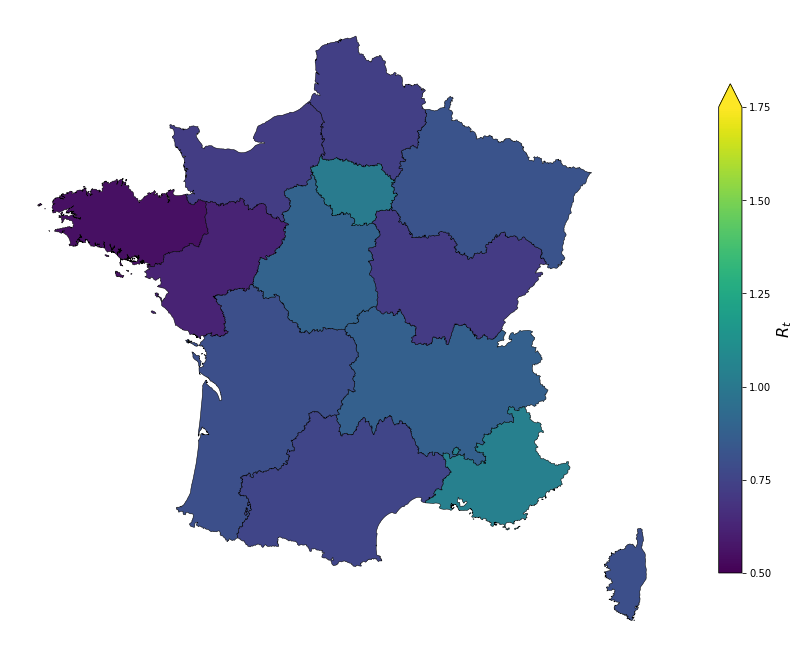

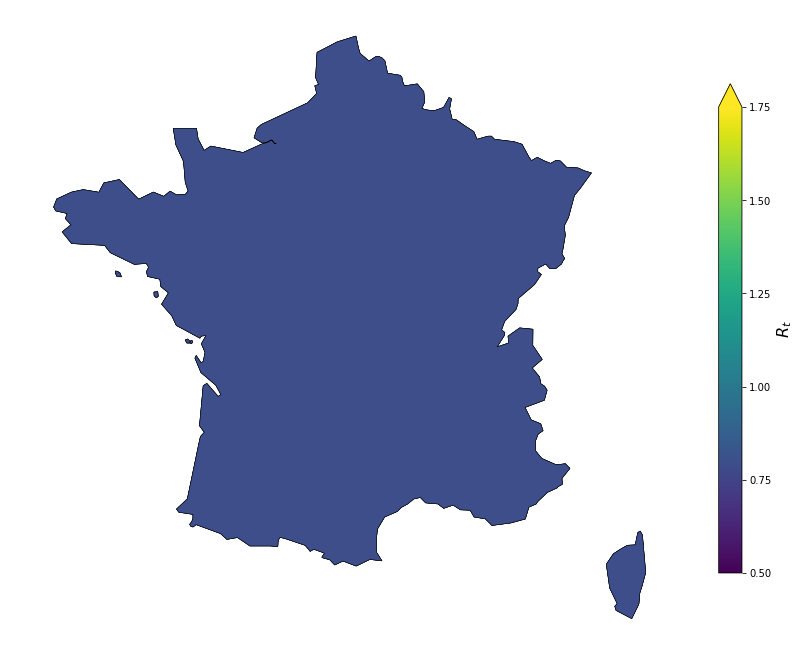

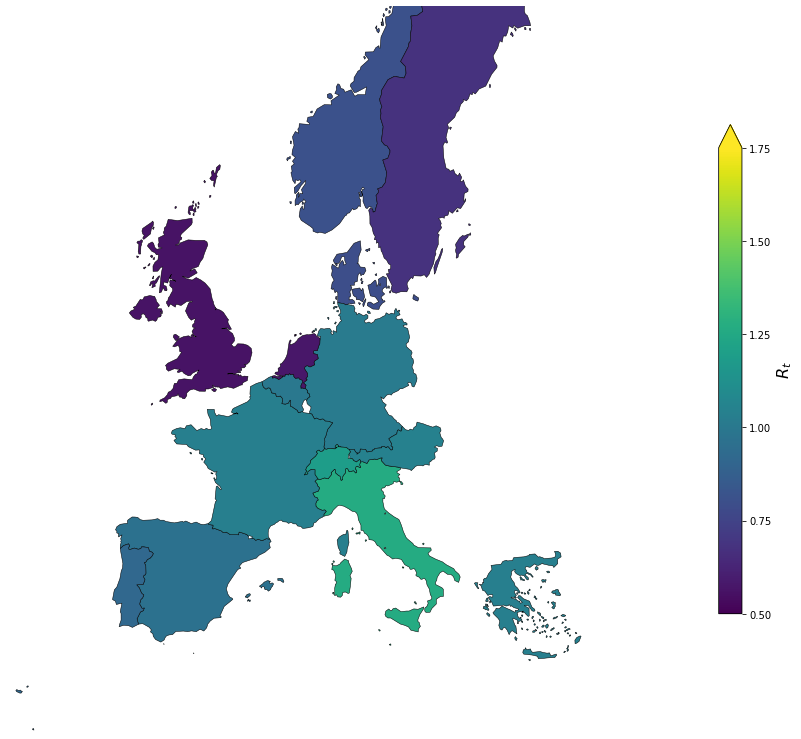

In [147]:

cmap, norm = rt_color_map()
for lvl in geo_df.geo_level.unique():
    print(f"Displaying level {lvl}")
    ax = geo_df[geo_df.geo_level == lvl].plot(
        column='rt',
        linewidth=0.5, edgecolor='k',
        norm=norm, cmap=cmap, 
    )

    # Hide grid lines
    cb = ax.figure.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax,
        shrink=0.6, extend='max',
        ticks=[0.5,0.75,1.0,1.25,1.5,1.75],
    )
    cb.set_label(label="$R_t$", fontsize=16)
    ax.set_axis_off()
    ax.figure.set_size_inches(15, 15)
    if lvl=="CNTRY":
        ax.set_xlim(-2e6,4e6)
        ax.set_ylim(0.35e7, 1.0e7)
    if lvl=="NATIONAL":
        ax.set_xlim(-653882.5665155814, 1145983.5555869662)
        ax.set_ylim(4987351.366469636, 6715609.314366471)
    

In [125]:
geo_df.geo_level.unique()

array(['REG', 'CNTRY'], dtype=object)

## Define processing functions